# Exercise 02
**Kernel Methods in Machine Learning (CS-E4830)**

**Release date**: 14th of February, 2020

**Submission date**: 5th of March, 2020 @4PM (no late submission allowed)

<div class="alert alert-success">
    <b>Tasks:</b>
    
1. [Implementing the Kernel Ridge Regression](#task_1) (**2 Point**)
2. [Kernel pre-processing](#task_2)
 1. [Centering](#task_2a) (**3 Points**)
 2. [Normalization](#task_2b) (**2 Point**)


**Version**: 2.0

**Version history**:

- 1.0: Initial version

<div class="alert alert-danger">
    Please add you student number and email address to the notebook into the corresponding cell.
</div>    

### EMAIL: amit.yadav@aalto.fi

### STUDENT_NUMBER:  	843717

## Import required python packages
All tasks in this exercise can be solved by using only function and packages imported below. Please **do not** use any other imports. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
from sklearn.metrics.pairwise import rbf_kernel as rbf_kernel_sk
from sklearn.metrics.pairwise import linear_kernel as linear_kernel_sk
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline

Wrapper around the sklearn `rbf_kernel` function. In the lecture, we use the formulation of the Gaussian kernel which includes $\sigma$ as parameter. However, sklearn uses a slighly different implementation, which is essentially just a re-parametrisation. We wrap the sklearn function, to be aligned with the lecture formulation. 

In [6]:
def gaussian_kernel_wrapper(X, Y=None, sigma=None):
    """
    Wrapper around the sklearn rbf-kernel function. It converts between the
    gamma parametrization (sklearn) and the sigma parametrization (lecture).
    """
    if sigma is None:
        sigma = np.sqrt(X.shape[1] / 2.)

    return rbf_kernel_sk(X, Y, gamma=(1. / (2. * (sigma**2))))

## 1. Kernel Ridge Regression (2 Point) <a id='task_1'></a>
The Kernel Ridge Regression prediction model can be written as:

$$
    g(\mathbf{x})=\sum_{i=1}^{n_{train}}\alpha_i \kappa(\mathbf{x},\mathbf{x}_i)=\mathbf{k}(\mathbf{x})\boldsymbol{\alpha}
$$
with:
- $g:\mathbb{R}^{d}\rightarrow\mathbb{R}$ being the **prediction function**
- $\mathbf{k}(\mathbf{x})=[\kappa(\mathbf{x},\mathbf{x}_1),\ldots,\kappa(\mathbf{x},\mathbf{x}_{n_{train}})]\in\mathbb{R}^{1\times n_{train}}$ being a row-vector containing all **similarities** between the new example $\mathbf{x}$ and the training examples $\mathbf{x}_i$
- $\boldsymbol{\alpha}\in\mathbb{R}^{n_{train}}$ column-vector containing the **dual variables**

Below you find the class-template for the Kernel Ridge Regression. It's functionality is split into three parts:

### 1. Intialization of Regressor Object using **__init__()**
A Kernel Ridge Regression instance can be created using its constructor, e.g.:
```python
# using a kernel function
est = KernelRidgeRegression(kernel="gaussian")

# or using precomputed kernel matrices
est = KernelRidgeRegression(kernel="precomputed")
```

### 2. Model Training using **fit()** 
This function takes as input:

- The features of the training examples $\mathbf{X}_{train}$ or a precomputed training kernel matrix $\mathbf{K}_{train}\in\mathbb{R}^{n_{train} \times n_{train}}$
- Their corresponding regression labels $\mathbf{y}_{train}\in\mathbb{R}^{n_{train}}$.

Using that, it estimates the dual variables $\alpha_i$'s. If needed, the kernel values between the training examples, i.e. $\kappa(\mathbf{x}_i, \mathbf{x}_j)$ are calculated during the fitting process.
```python
est.fit(X_train, y_train)

# or using precomputed kernel matrices
KX_train = my_kernel_function(X_train)
est.fit(KX_train, y_train)
```

### 3. Prediction for new Examples using **predict()** 
When the model parameters are fitted, than we can make predictions for a new example $\mathbf{x}$ using the function $g(\mathbf{x})$. 
```python
y_test_pred = est.predict(X_test)

# or using precomputed kernel matrices
KX_test_train = my_kernel_function(X_test, X_train)
y_test_pred = est.predict(KX_test_train, y_train)
```

<div class="alert alert-success">
    <b>Task:</b> Implement the missing code parts of <code>fit()</code> and <code>predict()</code>. Make use of the formula provided in the lecture and above. Try to avoid the explicit calculation of the matrix-inverse, but use the <code>np.linalg.solve</code> function. Do <b>not</b> use loops for the implementation, but NumPy matrix operations.
</div>

<div class="alert alert-warning">
    <b>Hint:</b> An example how to circumvent the direct calculation of the matrix-inverse, can be found in the $\mathbf{Python~ tutorial}$, under "$\mathbf{Matrix~ Inverse}$" section of this course.
</div>

In [21]:
class KernelRidgeRegression(BaseEstimator, RegressorMixin):
    def __init__(self, kernel="gaussian", beta=1.0, sigma=None):
        """
        Kernel Ridge Regression (KRR)

        :param kernel: string, specifying which kernel to use. Can be 'gaussian', 'linear' or 'precomputed'.
        :param beta: scalar, regularization parameter
        :param gamma: scalar, gaussian-kernel parameter
        """
        self.beta = beta
        self.X_train = None
        self.alphas = None

        # Set up kernel function
        self.kernel = kernel
        self.sigma = sigma

    def fit(self, X_train, y_train):
        """
        Fit a KRR model using training data.

        :param X_train: array-like, shape=(n_samples, n_features), feature-matrix
            OR X_train: array-like, shape=(n_samples, n_samples), precomputed kernel matrix
        :param y_train: array-like, shape=(n_samples,) or (n_samples, 1), label vector
        """
        # Make label vector to column-vector
        if len(y_train.shape) == 1:
            y_train = y_train[:, np.newaxis]
            
        # Calculate training kernel
        if self.kernel != "precomputed":
            self.X_train = X_train
            KX_train = self._get_kernel(self.X_train)
        else:
            KX_train = X_train
            
        # Calculate the identity matrix scaled by the regularization parameter: (beta * n_samples) * I
        # YOUR CODE HERE
        n_train = X_train.shape[0]
        IDM = n_train * self.beta * np.identity(n_train)
#         raise NotImplementedError()
        
        # Solve: alphas' = y' * inv(K + beta * n_samples * I), shape = (n_samples, 1)
        # YOUR CODE HERE
        self.alphas = np.linalg.solve((KX_train + IDM), y_train)
#         raise NotImplementedError()
        
        return self

    def predict(self, X):
        """
        Predict using fitted KRR model for new data.

        :param X: array-like, shape=(n_samples_test, n_features), feature-matrix of new data.
            OR X: array-like, shape=(n_samples_test, n_samples_train), test-training kernel matrix.
        :return: array-like, shape=(n_samples_test,), predictions for all data points
        """
        if self.alphas is None:
            raise RuntimeError("Call fit-function first.")
            
        if self.kernel != "precomputed":
            K_test_train = self._get_kernel(X, self.X_train)
        else:
            K_test_train = X
            if K_test_train.shape[1] != self.alphas.shape[0]:
                raise RuntimeError("Number of training examples does not match the shape of the "
                                   "provided Test-Train-Kernel matrix.")

        # Calculate the value of the prediction function for each test example
        # YOUR CODE HERE
        g_X = np.dot(K_test_train, self.alphas)
#         raise NotImplementedError()
                
        return g_X.flatten()

    def _get_kernel(self, X, Y=None):
        """
        Calcualte kernel matrix using specified kernel-function and parameters.

        :param X: array-like, shape=(n_samples_A, n_features), feature-matrix of set A
        :param Y: array-like, shape=(n_samples_B, n_features), feature-matrix of set B or None, than Y = X
        :return: array-like, shape=(n_samples_A, n_samples_B), kernel matrix
        """
        if self.kernel == "gaussian":
            return gaussian_kernel_wrapper(X, Y, self.sigma)
        elif self.kernel == "linear":
            return linear_kernel_sk(X, Y)
        elif self.kernel == "precomputed":
            raise RuntimeError("Provide precomputed kernel matrix.")
        else:
            raise ValueError("Invalid kernel chosen.")

In [22]:
from sklearn.kernel_ridge import KernelRidge as sk_KernelRidgeRegression

__X, __y = make_regression(n_samples=500, random_state=319)

# Split to train and test
__X_train, __X_test, __y_train, __y_test = train_test_split(__X, __y, random_state=731)

# Set up estimators
__gamma = 0.15
__KRR = KernelRidgeRegression(beta=0.5 / __X_train.shape[0], kernel="gaussian", sigma=np.sqrt(1. / (2 * __gamma)))
__KRR_ref = sk_KernelRidgeRegression(alpha=0.5, kernel="rbf", gamma=__gamma)

# Fit models
__KRR.fit(__X_train, __y_train)
__KRR_ref.fit(__X_train, __y_train)
np.testing.assert_equal(__KRR.alphas.shape, (__X_train.shape[0], 1))

# Predict
__y_pred = __KRR.predict(__X_test)
__y_pred_ref = __KRR_ref.predict(__X_test)
np.testing.assert_allclose(__y_pred, __y_pred_ref)

# MSE
np.testing.assert_allclose(mean_squared_error(__y_test, __y_pred), 
                           mean_squared_error(__y_test, __y_pred_ref))


**Visually inspect your KRR implementation**:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 'shape' argument should be used instead of 'dims'
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 'shape' argument should be used instead of 'dims'
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 'shape' argument should be used instead of 'dims'
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 'shape' argument should be used instead of 'dims'
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 'shape' argument should be used instead of 'dims'
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 'shape' argument should be used instead of 'dims'
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 'shape' argument should be used instead of 'dims'
/opt/conda/lib/python3.7/site-packages/ipykernel_launch

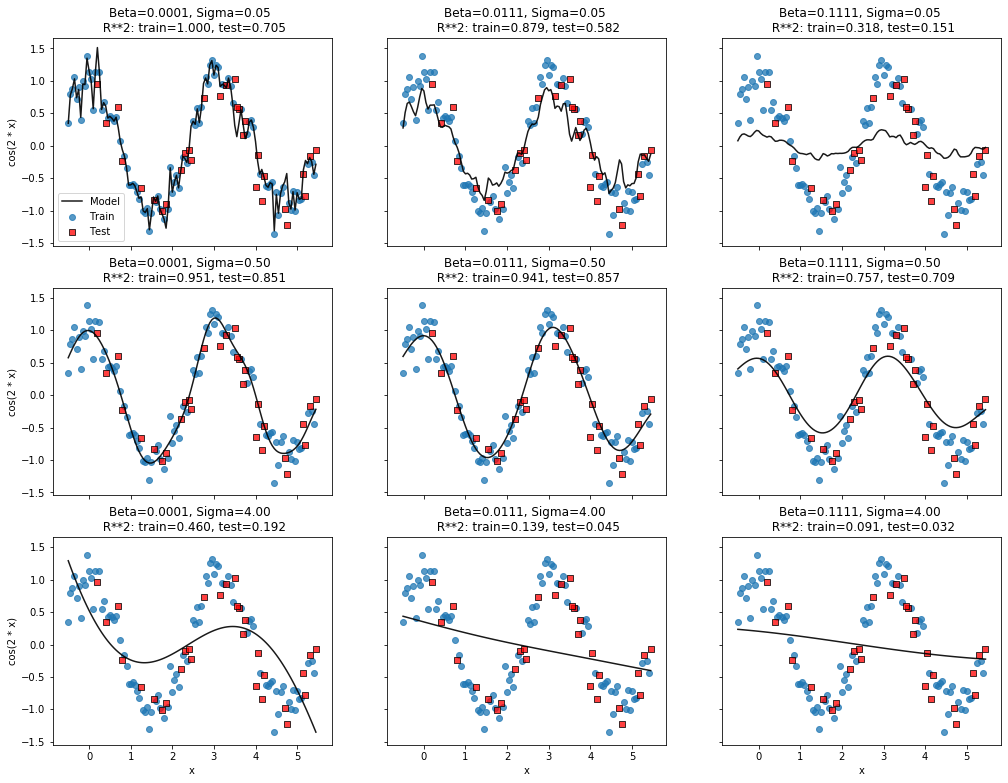

In [23]:
rng = np.random.RandomState(320)

# Generate noise cosine curve
X = np.arange(-0.5, 5.5, 0.05)[:, np.newaxis]
y = np.cos(2*X) + rng.randn(X.shape[0], 1) * 0.2

# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=767)

sigmas = [0.05, 0.5, 4.]
betas = np.array([0.01, 1, 10]) / len(X_train)

fig, axr = plt.subplots(len(sigmas), len(betas), 
                        figsize=(17, 13), sharex="all", sharey="all")

for idx, (s, b) in enumerate(it.product(sigmas, betas)):
    krr = KernelRidgeRegression(beta=b, sigma=s, kernel="gaussian")
    krr.fit(X_train, y_train)
    y_pred = krr.predict(X)
    
    # Calculate prediction score: sklear default for regression is R^2
    score_train = krr.score(X_train, y_train)
    score_test = krr.score(X_test, y_test)
    
    i, j = np.unravel_index(idx, dims=axr.shape)
    axr[i, j].plot(X, y_pred, label="Model", c="black", alpha=0.9)
    axr[i, j].scatter(X_train, y_train, label="Train", alpha=0.75)
    axr[i, j].scatter(X_test, y_test, label="Test", alpha=0.75, c="red",
                      marker="s", edgecolors="black")
    axr[i, j].set_title("Beta=%.4f, Sigma=%.2f \n R**2: train=%.3f, test=%.3f" % 
                        (b, s, score_train, score_test))
    
    if i == (len(sigmas) - 1):
        axr[i, j].set_xlabel("x")
    if j == 0:
        axr[i, j].set_ylabel("cos(2 * x)")

_ = axr[0, 0].legend(loc="lower left")

## 2. Kernel pre-processing <a id='task_2'></a>

In this task you will implement two kernel (matrix) pre-processing steps. The first one is *kernel centering* and the second one *kernel normalization*. In practice this steps might lead to better regression models and you usually should try at least to use centered kernels.

### A. Kernel centering (3 Points) <a id='task_2a'></a>
In the Pen & Paper exercise you showed, that the kernel centering (centering of the underlying feature vectors) can be done implicitly by transforming the kernel values. That means, you can calculate the simimlarity of the centered kernel between two samples $\kappa_c(\mathbf{x}_i, \mathbf{x}_j)$ using:

$$
    \kappa_c(\mathbf{x}_i, \mathbf{x}_j)=\kappa(\mathbf{x}_i, \mathbf{x}_j) - \frac{1}{n_{train}}\sum_{p\in\mathcal{I}_{train}}\kappa(\mathbf{x}_i, \mathbf{x}_p) - \frac{1}{n_{train}}\sum_{p\in\mathcal{I}_{train}}\kappa(\mathbf{x}_p, \mathbf{x}_j)+\frac{1}{n_{train}^2}\sum_{p\in\mathcal{I}_{train}}\sum_{q\in\mathcal{I}_{train}}\kappa(\mathbf{x}_p, \mathbf{x}_q)
$$

Here we assume that $i\in\mathcal{I}_A$ and $j\in\mathcal{I}_{B}$ are samples indices from two samples sets $A$ and $B$. The indices of the training examples are denoted with $\mathcal{I}_{train}$.

In practice we apply the centering to three matrices:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;border-color:#ccc;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-top-width:1px;border-bottom-width:1px;border-color:#ccc;color:#333;background-color:#fff;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-top-width:1px;border-bottom-width:1px;border-color:#ccc;color:#333;background-color:#f0f0f0;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg" style="width: 80%">
  <tr>
    <th class="tg-0pky">Kernel Matrix</th>
    <th class="tg-0pky">Notation</th>
    <th class="tg-0pky">$\mathcal{I}_A$</th>
    <th class="tg-0pky">$\mathcal{I}_B$</th>
    <th class="tg-0pky">Note</th>
  </tr>
  <tr>
    <td class="tg-0lax">Training kernel matrix</td>
    <td class="tg-0lax">$\mathbf{K}_{train}\in\mathbb{R}^{n_{train}\times n_{train}}$</td>
    <td class="tg-0lax">$\mathcal{I}_{train}$</td>
    <td class="tg-0lax">$\mathcal{I}_{train}$</td>
    <td class="tg-0lax">Used for fitting.</td>
  </tr>
  <tr>
    <td class="tg-0lax">Test-training kernel matrix</td>
    <td class="tg-0lax">$\mathbf{K}_{test,train}\in\mathbb{R}^{n_{test}\times n_{train}}$</td>
    <td class="tg-0lax">$\mathcal{I}_{test}$</td>
    <td class="tg-0lax">$\mathcal{I}_{train}$</td>
    <td class="tg-0lax">Used during prediction.</td>
  </tr>
  <tr>
    <td class="tg-0lax">Test-test kernel matrix</td>
    <td class="tg-0lax">$\mathbf{K}_{test,test}\in\mathbb{R}^{n_{test}\times n_{test}}$</td>
    <td class="tg-0lax">$\mathcal{I}_{test}$</td>
    <td class="tg-0lax">$\mathcal{I}_{test}$</td>
    <td class="tg-0lax">Needed for kernel normalizaton only.</td>
  </tr> 
</table>

#### Implementing a kernel centering class
We can implement the kernel centering as [sklearn transformer class](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html#sklearn.base.TransformerMixin). It requires us to implement a ```__init__()```, ```fit()``` and ```transform()``` function. 

##### 1. Intialization of transformer object using '__init__()'
We can get a KernelCentering instance using:
```python
centerer = KernelCentering()
```
##### 2. Fitting the centering statistics based on the training set using 'fit()'
We fit the necessary centering statistics using a training kernel matrix:
```python
centerer.fit(KX_train)
```
For that we calculate a the column-wise kernel value averages of the training kernel matrix $\mathbf{K}_{train}$ and store them in a vector $\bar{\mathbf{k}}_{train}\in\mathbb{R}^{1\times n_{train}}$:

$$
    [\bar{\mathbf{k}}_{train}]_i = \frac{1}{n_{train}}\sum_{p\in\mathcal{I}_{train}}\kappa(\mathbf{x}_i, \mathbf{x}_p) = \frac{1}{n_{train}}\sum_{p\in\mathcal{I}_{train}}[\mathbf{K}_{train}]_{ip} \quad\forall_{i \in \mathcal{I}_{train}}.
$$

We furthermore need to calculate the mean value of *all* kernel values $\mu_{train}\in\mathbb{R}$:

$$
    \mu_{train} = \frac{1}{n_{train}^2}\sum_{p\in\mathcal{I}_{train}}\sum_{q\in\mathcal{I}_{train}}\kappa(\mathbf{x}_p, \mathbf{x}_q) =\sum_{p\in\mathcal{I}_{train}}\sum_{q\in\mathcal{I}_{train}}[\mathbf{K}_{train}]_{pq}
$$

##### 3. Center train and test-train kernel matrix using 'transform()'
We can transform center a given kernel matrix:
```python
# Training kernel matrix
KX_train_c = centerer.transform(KX_train)  # I_A = I_train

# Test-Training kernel matrix
KX_test_train_c = centerer.transform(KX_test_train)  # I_A = I_test
```

For that we need to calculate the average kernel value between each example of $\mathcal{I}_A$ and the training set $\mathcal{I}_{train}$. We store this values in a column-vector $\bar{\mathbf{k}}_{A,train}\in\mathbb{R}^{n_{A}}$: 

$$
    [\bar{\mathbf{k}}_{A,train}]_i = \frac{1}{n_{train}}\sum_{p\in\mathcal{I}_{train}}\kappa(\mathbf{x}_i, \mathbf{x}_p) = \frac{1}{n_{train}}\sum_{p\in\mathcal{I}_{train}}[\mathbf{K}_{A,train}]_{ip} \quad\forall_{i \in \mathcal{I}_{A}}.
$$

##### 4. Center test-test kernel matrix using 'transform_k_test()'
To center the test-test kernel matirx, we $\mathbf{K}_{A,A}$ and $\mathbf{K}_{A,train}$:
```python
centerer.transform_k_test(KX_test, KX_test_train)
```

For that we (again) need to calculate the average kernel value between each example of $\mathcal{I}_A$ and the training set $\mathcal{I}_{train}$. We store this values in a column-vector $\bar{\mathbf{k}}_{A,train}\in\mathbb{R}^{n_{A}}$: 

$$
    [\bar{\mathbf{k}}_{A,train}]_i = \frac{1}{n_{train}}\sum_{p\in\mathcal{I}_{train}}\kappa(\mathbf{x}_i, \mathbf{x}_p) = \frac{1}{n_{train}}\sum_{p\in\mathcal{I}_{train}}[\mathbf{K}_{A,train}]_{ip} \quad\forall_{i \in \mathcal{I}_{A}}.
$$


<div class="alert alert-success">
    <b>Task:</b> Implement the missing code parts of <code>fit()</code>, <code>transform()</code> and <code>transform_K_test()</code>. Make use of the formulas provided above and the Pen & Paper exercise. Do <b>not</b> use loops for the implementation, but NumPy matrix operations.
</div>

<div class="alert alert-warning">
    <b>Hints:</b>
    
- You can calculate the mean (average) value along different axes of a matrix using <code>np.mean</code>.
- Take a look on the NumPy [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html). What is the result of the following instructions:
    
```python
M = np.arange(12).reshape((4, 3))
print(M)

a = np.array([[1, 2, 3]])  # shape = (1, 3)
print(a)
    
print(M - a)  # ???
```
</div>

In [38]:
M = np.arange(12).reshape((4, 3))
print(M)

a = np.array([[1, 2, 3]])  # shape = (1, 3)
print(a)

print(M - a)  # ???

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]
[[1 2 3]]
[[-1 -1 -1]
 [ 2  2  2]
 [ 5  5  5]
 [ 8  8  8]]


In [50]:
np.sum(M - np.mean(M, axis=0), axis=0)

array([0., 0., 0.])

In [55]:
M = np.arange(12).reshape((12,1))

In [75]:
class KernelCenterer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Centering statistics
        self.k_bar_train = None
        self.mu_train = None

    def fit(self, K, y=None, **fit_params):
        """
        Extract the data statistics needed for the kernel centering.

        :param K: array-like, shape=(n_samples_train, n_samples_train), kernel matrix
        :param y: array-like, shape=(n_samples,), target values. Will be ignored. 
        :return: self, returns an instance of it self.
        """
        # Calculate the statistics from the training set:
        # - k_bar_train, shape = (1, n_train)
        # - mu_train, scalar
        # YOUR CODE HERE
        self.k_bar_train = np.mean(K, axis=0, keepdims=True)
        self.mu_train = np.mean(K)
#         print("k_bar_train.shape: ", self.k_bar_train.shape)
#         print("mu: ", self.mu_train)
#         raise NotImplementedError()

        return self  # allows to use the fit_transform method inhered from TransformerMixin

    def transform(self, K, y=None, copy=True, K_test=False):
        """
        Apply centering to a kernel matrix.

        :param K: array-like, shape=(n_samples_A, n_samples_train)
        :param y: array-like, shape=(n_samples_A,), target values. Will be ignored!
        :param copy: boolean, indicating whether the input kernel matrix should be copied before so that the
            centering does not effect the original matrix.
        :return: array-like, shape=(n_samples_A, n_samples_train) centered kernel matrix.
        """
#         print("K.shape: ", K.shape)
        # Copy input array, if copy=True, i.e. original data is not modified.
        if copy:
            K = np.array(K)

        # Calculate: k_bar_A_train, shape = (n_test, 1) by averaging along the rows
        # YOUR CODE HERE
        k_bar_A_train = np.mean(K, axis=1, keepdims=True)
#         raise NotImplementedError()
        assert(k_bar_A_train.shape == (K.shape[0], 1))
#         print("k_bar_A_train.shape: ", k_bar_A_train.shape)
        
        # Center kernel matrix
        # YOUR CODE HERE
        K = K - (k_bar_A_train + self.k_bar_train) + self.mu_train
#         print("K centered sum, axis = 0: ", np.sum(K, axis=0))
#         print("K centered sum, axis = 1: ", np.sum(K, axis=1))
#         raise NotImplementedError()

        return K
    
    def transform_K_test(self, K, K_test_train, copy=True):
        """
        Apply centering the test-test kernel matrix. This case needs to be handled separetly.
        
        :param K: array-like, shape=(n_samples_A, n_samples_A), test-test kernel matrix
        :param K_test_train: array-like, shape=(n_samples_A, n_samples_train)
        :param copy: boolean, indicating whether the input kernel matrix should be copied before so that the
            centering does not effect the original matrix.
        :return: array-like, shape=(n_samples_A, n_samples_A) centered kernel matrix
        """
        # Copy input array, if copy=True, i.e. original data is not modified.
        if copy:
            K = np.array(K)
            
        # Calculate: k_bar_A_train, shape = (n_test, 1) by averaging along the rows of K_test_train
        # YOUR CODE HERE
        k_bar_A_train = np.mean(K_test_train, axis=1, keepdims=True)
#         raise NotImplementedError()
        assert(k_bar_A_train.shape == (K.shape[0], 1))
        
        # Center test-test kernel matrix K
        # YOUR CODE HERE
        K = K - (k_bar_A_train + k_bar_A_train.T) + self.mu_train
#         raise NotImplementedError()
        
        return K

    @property
    def _pairwise(self):
        return True

In [76]:
__rng = np.random.RandomState(890)
__X = __rng.rand(101, 31)
__KX = rbf_kernel_sk(__X, gamma=1.2)

# Fit your centerer using some training data
__centerer = KernelCenterer().fit(__KX[:75, :75])
np.testing.assert_equal(__centerer.k_bar_train.shape, (1, 75))
assert(np.isscalar(__centerer.mu_train))

# Transform your training data
__KX_train_c = __centerer.transform(__KX[:75, :75])
np.testing.assert_equal(__KX_train_c.shape, (75, 75))
np.testing.assert_allclose(np.sum(__KX_train_c, axis=0), 
                           np.zeros((__KX_train_c.shape[0],)), atol=1e-12)
np.testing.assert_allclose(np.sum(__KX_train_c, axis=1),
                           np.zeros((__KX_train_c.shape[0],)), atol=1e-12)

# Transform your test-training data
__KX_test_train_c = __centerer.transform(__KX[75:, :75])
np.testing.assert_equal(__KX_test_train_c.shape, (26, 75))

# We test the test-test kernel centering by centering the features in the original space and construct a
# linear kernel on top. In this case, centering the kernel implicitly is equivalent to centering it in the
# feature space.
__X_train, __X_test = train_test_split(__X, random_state=380)

__feat_centerer = StandardScaler(with_std=False).fit(__X_train)
__X_train_c = __feat_centerer.transform(__X_train) 
__X_test_c = __feat_centerer.transform(__X_test)

__KX_lin_train = linear_kernel_sk(__X_train, __X_train)
__KX_lin_test_train = linear_kernel_sk(__X_test, __X_train)
__KX_lin_test = linear_kernel_sk(__X_test, __X_test)

# build kernels based on centered feature vectors
__KX_lin_train_c = linear_kernel_sk(__X_train_c, __X_train_c)
np.testing.assert_allclose(np.sum(__KX_lin_train_c, axis=0), 
                           np.zeros((__KX_lin_train_c.shape[0],)), atol=1e-12)

__centerer = KernelCenterer().fit(__KX_lin_train)
__KX_lin_test_c = __centerer.transform_K_test(__KX_lin_test, __KX_lin_test_train)
__KX_lin_test_c_ref = linear_kernel_sk(__X_test_c, __X_test_c)

np.testing.assert_allclose(__KX_lin_test_c, __KX_lin_test_c_ref)


### B. Kernel normalization (2 Point) <a id='task_2b'></a>

Using a normalized kernel can be in practice lead to better models, e.g. less senstive to outliers. As for the kernel centering, if we choose the type of normalization properly, we can calculate the normalized kernel without explicit knowledge of the underlying featurespace. 

Given a kernel matrix $\mathbf{K}_{A,B}$ between to sets of samples $A$ and $B$, we can normalize its entries $\kappa(\mathbf{x}_i, \mathbf{x}_j)$, with $i\in\mathcal{I}_A$ and $j\in\mathcal{I}_B$, as follows:

$$
    \kappa(\mathbf{x}_i, \mathbf{x}_j) = \frac{\kappa(\mathbf{x}_i, \mathbf{x}_j)}
        {\sqrt{\kappa(\mathbf{x}_i, \mathbf{x}_i)\kappa(\mathbf{x}_j, \mathbf{x}_j)}}.
$$

The feature-vectors $\phi(\mathbf{x})$ are implicitly normalized, such that: 

$$
    \phi(\mathbf{x})_n = \frac{\phi(\mathbf{x})}{\|\phi(\mathbf{x})\|} = \frac{\phi(\mathbf{x})}{\sqrt{\phi(\mathbf{x})^T\phi(\mathbf{x})}}
$$


<div class="alert alert-success">
    <b>Task:</b> Implement the missing code parts of <code>normalize_kernel()</code>. Do <b>not</b> use loops for the implementation, but NumPy matrix operations.
</div>

<div class="alert alert-warning">
    <b>Hint:</b> 
    
- Read the documentation of the NumPy function [<code>np.outer</code>](https://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html#numpy.outer). How can it help you to construct a matrix $D\in\mathbb{R}^{n_A \times n_B}$ such that:
$$
    [D]_{ij} = \kappa(\mathbf{x}_i, \mathbf{x}_i)\kappa(\mathbf{x}_j, \mathbf{x}_j)\quad?
$$
- Make use of element-wise division.
</div>

In [89]:
def normalize_kernel(K, d_A, d_B=None, copy=True):
    """
    Function implementing the kernel normalization. 
    
    :param K: array-like, shape=(n_samples_A, n_samples_B), kernel matrix to normalize
    :param d_A: array-like, shape=(n_samples_A,) diagonal of the kernel matrix K_AA
    :param d_A: array-like, shape=(n_samples_B,) diagonal of the kernel matrix K_BB
    :param copy: boolean, indicating whether the input kernel matrix should be copied before 
        normalization.
    :return: array-like, shape=(n_samples_A, n_samples_B) normalized kernel matrix.
    """
    # Copy input array, if copy=True, i.e. original data is not modified.
    if copy:
        K = np.array(K)
        
    if K.shape[0] != len(d_A):
        raise ValueError("Number of elements of d_A must match the number of rows if K.")
        
    if d_B is None:
        d_B = d_A
        
    if K.shape[1] != len(d_B):
        raise ValueError("Number of elements of d_B must match the number of columns if K.")
        
    # Normalize kernel matrix
    # YOUR CODE HERE
    temp = np.sqrt( np.dot( d_A.reshape((d_A.size, 1)), d_B.reshape((d_B.size, 1)).T ) )
    K = np.divide(K, temp)
#     raise NotImplementedError()
    
    return K

In [80]:
M = np.arange(12).reshape((3,4))

In [90]:
#test performance with the sklearn as refrence
__rng = np.random.RandomState(9212)
__X = __rng.rand(239, 22)
__X_n = Normalizer(norm="l2").fit_transform(__X)  # phi(x)_n = phi(x) / ||phi(x)||, linear kernel

__KX = linear_kernel_sk(__X, __X)
__KX_n_ref = linear_kernel_sk(__X_n, __X_n)

__KX_n = normalize_kernel(__KX, np.diag(__KX), np.diag(__KX))
assert(np.all(np.diag(__KX_n) == 1.))
np.testing.assert_allclose(__KX_n, __KX_n_ref)

__KX_test_train_n = normalize_kernel(__KX[75:, :75], np.diag(__KX[75:, 75:]), np.diag(__KX[:75, :75]))
__KX_test_train_n_ref = linear_kernel_sk(__X_n[75:], __X_n[:75])
np.testing.assert_allclose(__KX_test_train_n, __KX_test_train_n_ref)